# Loan Recommendation System
## POC - Proof Of Concept

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
# from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import Normalizer
# from pyspark.sql.functions import mean
# from pyspark.sql.window import Window
# from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [4]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data_V-2.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)



In [5]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).describe().show(10)

+-------+------------------+-----------------+-------------------+--------------------+------------------+
|summary|    Cluster_result|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|
+-------+------------------+-----------------+-------------------+--------------------+------------------+
|  count|            481071|           481071|             481071|              481071|            481071|
|   mean| 99.84271760301493|861.5759420127174|  7.075398433911003|                NULL|1.6787376499518782|
| stddev|103.48255516647191|809.0576736930875|  4.136543039007542|                NULL|0.8991013265350534|
|    min|                -1|              100|                  1|         Fortnightly|                 0|
|    max|               735|             5000|                 45|              Weekly|                 8|
+-------+------------------+-----------------+-------------------+--------------------+------------------+



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4>
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>
    ->
StageName: Current stage of the loan application (e.g., application, approved, rejected).    ->
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>
    ->
userId: Unique identifier for a user Account Id in Numericr).    ->
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [6]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+--------------+------+-------------------+--------------------+-----+
|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+--------------+------+-------------------+--------------------+-----+
|            16|   500|                 10|              Weekly|    3|
|           104|   700|                 10|              Weekly|    3|
|           106|   800|                 10|              Weekly|    3|
|           106|   800|                 10|              Weekly|    3|
|           106|   800|                 10|              Weekly|    3|
|           106|   800|                 10|              Weekly|    3|
|           106|   800|                 10|              Weekly|    3|
|            70|   900|                 10|              Weekly|    3|
|           109|  1000|                 10|              Weekly|    3|
|           109|  1000|                 10|              Weekly|    3|
+--------------+------+-------------------+--------------------+-----+
only s

### Removing the outliers point created by the DBSCAN Clustering Algorithm

In [28]:
loans_df =  loans_df.filter(loans_df.Cluster_result != -1)

In [31]:
loans_df.filter(loans_df.Cluster_result == -1).select("Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count").show(50)

+--------------+------+-------------------+--------------------+-----+
|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+--------------+------+-------------------+--------------------+-----+
+--------------+------+-------------------+--------------------+-----+



### Aggregating the loans per user (getting all loans for each user user)

In [32]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [33]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [34]:
loans_df.select(["userId","Cluster_result","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|    Cluster_result|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            478384|            478384|            478384|           478384|             478384|                    478384|              478384|
|   mean|24297.387245392823|100.40913366667782|  1.67947088531389|852.6524716545704| 7.0411865781464265|        11.983703468343423|  11.945067142713803|
| stddev|15279.533618278248|103.49564260058312|0.8993274813356014|796.6316498091028|  4.081996314331494|         8.182142009614276|   8.305112610291307|
|    min|                 1|                 0|                 0|              10

#### Plotting the Frequnecy of Count(Ratings)

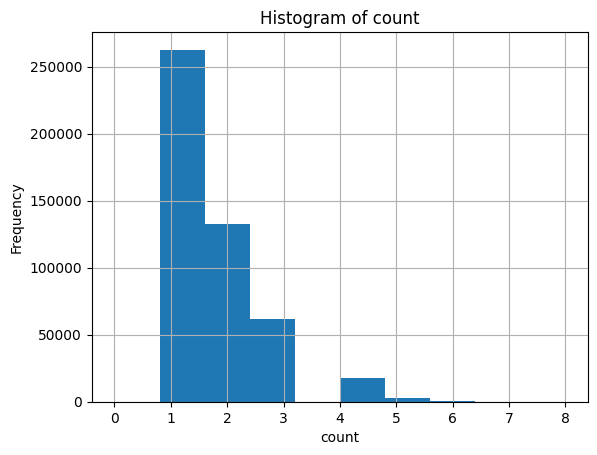

In [35]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

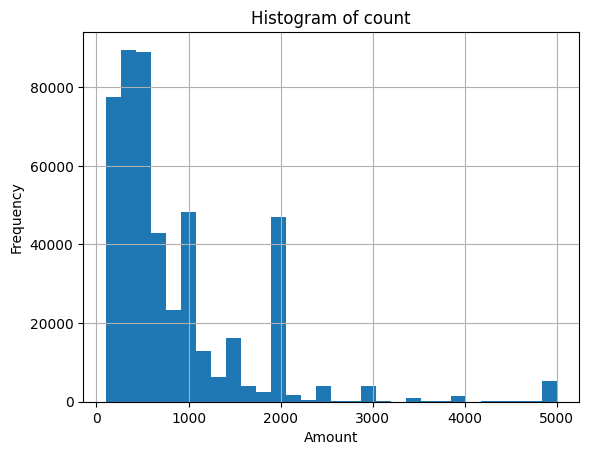

In [122]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [36]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 736
Number of unique Loan Id: 404979


In [37]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59150


#### Values of count(Rating) Column.

In [38]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train test and validation split.

In [39]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Amount"]).show(10)

+--------------+-----+------+
|Cluster_result|count|Amount|
+--------------+-----+------+
|            16|    3|   500|
|           104|    3|   700|
|           106|    3|   800|
|           106|    3|   800|
|           106|    3|   800|
|           106|    3|   800|
|           106|    3|   800|
|            70|    3|   900|
|           109|    3|  1000|
|           109|    3|  1000|
+--------------+-----+------+
only showing top 10 rows



In [40]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, Cluster_result: int, userId: int, loanId: int, count: int]

In [41]:
validation.select(["userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+------+------+--------------+-----+------+-------------------+
|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+------+------+--------------+-----+------+-------------------+
|   130|     6|            14|    3|   400|                 10|
|   138|    14|            11|    1|  1000|                 10|
|   144|    21|            14|    2|   400|                 10|
|   145|    22|            88|    4|   350|                  5|
|   149|    29|            47|    1|   200|                 10|
|   156|    44|           147|    3|   900|                  3|
|   161|    50|            14|    1|   500|                  3|
|   165|    54|            10|    1|   500|                 10|
|   172|    64|            41|    1|   300|                  2|
|   178|    74|            60|    1|   250|                  2|
|   180|    79|            29|    1|   400|                  5|
|   181|    81|            78|    3|   200|                  5|
|   186|    99|            45|    1|   3

In [42]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)



In [43]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [44]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.10187361528985578
8 latent factors and regularization = 0.01: validation RMSE is 0.04840035933633036
8 latent factors and regularization = 0.05: validation RMSE is 0.08585059416102922
8 latent factors and regularization = 0.1: validation RMSE is 0.12721832695999494
8 latent factors and regularization = 0.2: validation RMSE is 0.22369376768988827
10 latent factors and regularization = 0.001: validation RMSE is 0.1802452272369306
10 latent factors and regularization = 0.01: validation RMSE is 0.04658875387432092
10 latent factors and regularization = 0.05: validation RMSE is 0.08614870444040466
10 latent factors and regularization = 0.1: validation RMSE is 0.12692880730784034
10 latent factors and regularization = 0.2: validation RMSE is 0.22354120995194743
20 latent factors and regularization = 0.001: validation RMSE is 0.2855640262699591
20 latent factors and regularization = 0.01: validation RMSE is 0.03564455963084388


In [63]:
final_model.save("Recommendation_ALS_Model")

## Predicting the results from validation data

In [64]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [65]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "Cluster_result", "prediction").show(20)

+------+------+-----+--------------+----------+
|userId|loanId|count|Cluster_result|prediction|
+------+------+-----+--------------+----------+
|    10|   127|    4|             0| 3.9766774|
|    10|  6663|    4|             3| 3.9851441|
|    10| 13864|    4|            12| 3.9934986|
|    10| 23209|    4|            15| 3.9498644|
|    10| 42894|    4|           104| 3.9114456|
|    10| 68823|    4|           104| 3.9114456|
|    10| 81289|    4|            16| 3.9572735|
|    10|137071|    4|            81| 4.0042477|
|    10|341925|    4|             8| 3.9165397|
+------+------+-----+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [66]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.03564455963084388


## Recommendation of N users

In [67]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [68]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [69]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)



In [70]:
validation.count()

95647

## ALS Model Evaluation

In [71]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'Cluster_result'], 'inner')

In [72]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(Cluster_result) as true_positives'))

In [73]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(Cluster_result) as relevant'))

In [74]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [75]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [76]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [77]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [78]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.1762519484351677
Overall Recall: 1.1762519484351677
Overall F1-score: 1.176251948435171


In [79]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [80]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.024878376597979087)

## User Factors and Item Factors to calculate the cosine Similarity

In [81]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [88]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

58816
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [85]:
userFactors.select("id","features").sort("id").show(10,truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                           |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |[0.015001243, 0.6066942, 0.6845103, 0.51255065, 0.7865024, 0.6892234, 0.14708628, 0.03684002, 0.9731985, 1.0706317, 1.4873204, 0.14643958, 0.5305877, 0.9596222, 0.6433107, 0.08504144, 0.65039366, 0.5983208, 0.93522793, 0.8337981]              |


In [86]:
itemFactors.select("id","features").sort("id").show(10,truncate=False)

+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                            |
+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[0.0, 0.18720071, 0.22617371, 0.16546613, 0.29441035, 0.16321693, 0.06773271, 0.0071068336, 0.28402752, 0.28087592, 0.41143826, 0.053187188, 0.084521644, 0.2418822, 0.16857909, 0.0, 0.2648601, 0.108785555, 0.22939037, 0.26659933]             

In [87]:
final_model.userFactors.orderBy("id").collect()

[Row(id=1, features=[0.015001242980360985, 0.606694221496582, 0.6845102906227112, 0.5125506520271301, 0.7865024209022522, 0.6892234086990356, 0.1470862776041031, 0.03684002161026001, 0.9731984734535217, 1.070631742477417, 1.4873204231262207, 0.1464395821094513, 0.5305876731872559, 0.9596222043037415, 0.6433107256889343, 0.08504144102334976, 0.6503936648368835, 0.5983207821846008, 0.9352279305458069, 0.8337981104850769]),
 Row(id=2, features=[0.018056480213999748, 0.3910137414932251, 0.4824093282222748, 0.3888395428657532, 0.5839208960533142, 0.432620644569397, 0.14514724910259247, 0.03623557463288307, 0.6015665531158447, 0.7152624130249023, 0.9611314535140991, 0.09309188276529312, 0.32696017622947693, 0.6211150884628296, 0.3953491747379303, 0.035474035888910294, 0.47304385900497437, 0.3682001531124115, 0.6733530163764954, 0.5994729995727539]),
 Row(id=3, features=[0.016663968563079834, 0.19272951781749725, 0.2467365562915802, 0.18259771168231964, 0.2857377827167511, 0.21329151093959808

In [89]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |Features                                                                                                                                                                                                                                            |
+---+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10 |[0.005702772, 0.7948517, 0.9861132, 0.7711443, 1.2123278, 0.81580627, 0.29171878, 0.068940364, 1.2487979, 1.3954464, 1.8910812, 0.19166145, 0.5880901, 1.2149551, 0.77889967, 0.044845723, 1.0102906, 0.6538951, 1.2880157, 1.2114111]            

## Calculate cosine similarity:

### user-User Cosine Similarity code

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [90]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [91]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9933014977743737


### User-Item Cosine Similarity code

In [92]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 10 and 1: 0.9994441797571979


###  Cosine Similarity of user 10 with all Loans

In [93]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [94]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.9997477359432444},
 {'userID': 10, 'LoanId': 13, 'CosineSimilarity': 0.9995098358858601},
 {'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9994441797571979},
 {'userID': 10, 'LoanId': 21, 'CosineSimilarity': 0.9994283409914382},
 {'userID': 10, 'LoanId': 158, 'CosineSimilarity': 0.9994100197691218},
 {'userID': 10, 'LoanId': 136, 'CosineSimilarity': 0.9992870755485301},
 {'userID': 10, 'LoanId': 11, 'CosineSimilarity': 0.9992275474759598},
 {'userID': 10, 'LoanId': 412, 'CosineSimilarity': 0.99918903287486},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.9991781991684039},
 {'userID': 10, 'LoanId': 71, 'CosineSimilarity': 0.9990142413227852},
 {'userID': 10, 'LoanId': 72, 'CosineSimilarity': 0.9989005642844984},
 {'userID': 10, 'LoanId': 721, 'CosineSimilarity': 0.9988823515391941},
 {'userID': 10, 'LoanId': 268, 'CosineSimilarity': 0.9987374243999623},
 {'userID': 10, 'LoanId': 16, 'CosineSimilarity': 0.9986383819671093},
 {'us

### Cosine Similarity of all users with all loans

In [95]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [96]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [97]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.08019051134586334 hours


In [98]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [99]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [109, 224, 283, 445, 106]},
 {'userId': 2, 'Recommendation': [1, 71, 8, 11, 13]},
 {'userId': 3, 'Recommendation': [466, 74, 1, 104, 71]},
 {'userId': 4, 'Recommendation': [52, 43, 48, 463, 55]},
 {'userId': 5, 'Recommendation': [4, 356, 397, 216, 729]},
 {'userId': 6, 'Recommendation': [250, 232, 134, 75, 410]},
 {'userId': 7, 'Recommendation': [710, 733, 4, 126, 681]},
 {'userId': 8, 'Recommendation': [226, 487, 275, 21, 109]},
 {'userId': 9, 'Recommendation': [161, 435, 369, 16, 69]},
 {'userId': 10, 'Recommendation': [8, 13, 1, 21, 158]},
 {'userId': 11, 'Recommendation': [16, 721, 232, 143, 69]},
 {'userId': 12, 'Recommendation': [42, 9, 29, 38, 4]},
 {'userId': 13, 'Recommendation': [38, 28, 639, 67, 732]},
 {'userId': 14, 'Recommendation': [9, 29, 22, 684, 548]},
 {'userId': 15, 'Recommendation': [11, 14, 71, 8, 105]},
 {'userId': 16, 'Recommendation': [4, 392, 38, 127, 497]},
 {'userId': 17, 'Recommendation': [14, 71, 11, 1, 8]},
 {'userId': 18,

In [100]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [101]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [283, 445, 217, 226, 275]},
 {'UserId': 2, 'Recommendations': [1, 71, 13, 72, 582]},
 {'UserId': 3, 'Recommendations': [466, 74, 1, 104, 71]},
 {'UserId': 4, 'Recommendations': [43, 48, 463, 55, 434]},
 {'UserId': 5, 'Recommendations': [4, 356, 397, 216, 729]},
 {'UserId': 6, 'Recommendations': [250, 232, 134, 75, 410]},
 {'UserId': 7, 'Recommendations': [710, 733, 4, 126, 681]},
 {'UserId': 8, 'Recommendations': [226, 487, 275, 21, 588]},
 {'UserId': 9, 'Recommendations': [161, 435, 369, 16, 69]},
 {'UserId': 10, 'Recommendations': [13, 21, 158, 136, 412]},
 {'UserId': 11, 'Recommendations': [721, 232, 143, 69, 161]},
 {'UserId': 12, 'Recommendations': [29, 38, 4, 22, 127]},
 {'UserId': 13, 'Recommendations': [38, 639, 732, 497, 470]},
 {'UserId': 14, 'Recommendations': [29, 684, 548, 128, 4]},
 {'UserId': 15, 'Recommendations': [71, 105, 13, 23, 362]},
 {'UserId': 16, 'Recommendations': [392, 38, 127, 497, 216]},
 {'UserId': 17, 'Recommendations': [7

In [102]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [103]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [104]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [105]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0232


In [95]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [102]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [103]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0024


##  Calculate centered cosine similarity:

In [106]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [107]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9782147349553701


### User-Item Centerd Cosine Similarity code

In [108]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9979352228452915


### Centered Cosine Similarity of user 10 with all Loans

In [109]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [110]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9990651532135731},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9981794555298428},
 {'userID': 10, 'LoanId': 158, 'CenteredSimilarity': 0.9979585051166067},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9979352228452915},
 {'userID': 10, 'LoanId': 21, 'CenteredSimilarity': 0.9978954557854395},
 {'userID': 10, 'LoanId': 136, 'CenteredSimilarity': 0.9973894878479216},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.997133090508883},
 {'userID': 10, 'LoanId': 412, 'CenteredSimilarity': 0.9970298018619497},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9969516745266924},
 {'userID': 10, 'LoanId': 71, 'CenteredSimilarity': 0.9964836926825581},
 {'userID': 10, 'LoanId': 72, 'CenteredSimilarity': 0.9961979950867996},
 {'userID': 10, 'LoanId': 721, 'CenteredSimilarity': 0.995930793016309},
 {'userID': 10, 'LoanId': 268, 'CenteredSimilarity': 0.9955857397598513},
 {'userID': 10, 'LoanId': 716, 'CenteredSimilarity

In [111]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 0, 'CenteredSimilarity': 0.979051952318717},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9979352228452915},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9780574775917291},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9729560805236233},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9678566398496377},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9828708715025081},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9852390246467995},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9760156267527729},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9990651532135731},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.923286102768848},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9818688511368276},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.997133090508883},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9660840393927226},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9981794555

## Cosine Similarity of all users with all loans

In [ ]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [112]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [113]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.08677323381106058 hours


In [114]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [115]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [116]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [117]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [118]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.0235


In [ ]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [ ]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1859|  2366|   500|                 10|    1| 0.9933492|
|           1| 18371|  4818|   600|                 10|    2| 1.9914738|
|           1| 24830|  1342|   500|                 10|    1| 0.9981674|
|           1| 39048|  1238|   500|                 10|    3|  2.984103|
|           1| 44319| 19984|   500|                  6|    3|  2.992899|
|           1| 44367| 16503|   300|                  6|    3| 2.9956226|
|           1| 44446| 15846|   200|                  6|    3|  2.991486|
|           1| 48006| 20683|   600|                 10|    1| 0.9933492|
|           1| 49432| 18866|   500|                  6|    1| 0.9981674|
|           1| 50698| 17420|   750|                 10|    1| 0.9965345|
|           1| 51505| 15447|   400|                

In [ ]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            111352|            111352|
|   mean| 1.661863417419055| 4.518930957683741|
| stddev|0.8937703516935817|2.7881530111682316|
|    min|               0.0|                 1|
|    max|         7.9761477|                20|
+-------+------------------+------------------+



In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [ ]:
print(f"The RMSE for the above m0odel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.028842204161434074


In [ ]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [ ]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+----------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                            |rating                                                 |
+------------+----------------------------------+-------------------------------------------------------+
|20          |[1832, 24495, 24531, 24991, 15933]|[7.950424, 7.0113587, 6.9573717, 6.0000634, 5.9925804] |
|10          |[1832, 24713, 24608, 24303, 24495]|[8.555681, 7.465768, 7.3844924, 7.339622, 7.0376883]   |
|1           |[1832, 24495, 24531, 15933, 24418]|[7.9761477, 7.0013914, 6.9772563, 6.0103855, 6.0089397]|
|11          |[1832, 24495, 24531, 15933, 24418]|[9.5949135, 8.382941, 8.35992, 7.275463, 7.274435]     |
|12          |[1832, 24495, 24531, 24991, 24301]|[7.973118, 7.0685134, 6.977419, 6.0400486, 6.019967]   |
|2           |[1832, 24495, 24531, 15933, 24418]|[7.9706793, 7.006312, 6.973244, 6.006671, 6.005226]    |
|13          |[1832, 24713, 24608, 24303, 2449

In [ ]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
userRecommends.filter(userRecommends.userId == 10 ).show(vertical=True,truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------
 userId          | 10                                                                                
 recommendations | [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 



In [ ]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+-------------------+--------------------------------------------------------+
|userId|LoanIdFormat       |rating                                                  |
+------+-------------------+--------------------------------------------------------+
|1     |[11, 19, 10, 5, 4] |[3.483842, 2.9951677, 2.9910934, 2.986418, 2.9808848]   |
|6     |[11, 19, 5, 10, 12]|[1.2100239, 1.0132257, 1.0107574, 1.0031507, 1.0014443] |
|12    |[11, 19, 5, 12, 10]|[2.4086132, 2.0269725, 2.0201576, 2.0100853, 2.0080824] |
|13    |[11, 19, 5, 10, 12]|[1.1989177, 1.0090533, 1.006838, 1.0012228, 0.99791485] |
|16    |[11, 19, 12, 5, 10]|[1.1825534, 1.0075336, 1.0040952, 1.0034789, 1.002596]  |
|22    |[11, 19, 5, 10, 1] |[1.1965677, 1.0075513, 1.0053955, 1.0006418, 0.99691176]|
|26    |[11, 19, 5, 10, 1] |[1.1896594, 1.0058196, 1.0035554, 0.99995625, 0.9963331]|
|27    |[11, 19, 5, 10, 1] |[1.1919556, 1.0058408, 1.0038042, 1.0001444, 0.99620336]|
|28    |[11, 10, 19, 5, 1] |[1.1703922, 0.99830914, 0.

In [ ]:
LoanRecommendation =  [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}]

In [ ]:
loanRecommend_user_10 = [{"userID":10,"LoanId":loanI,"Ratings":ratin} for loanI,ratin in LoanRecommendation]

In [ ]:
sorted(loanRecommend_user_10, key=operator.itemgetter('Ratings'),reverse=True )

[{'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896}]

In [ ]:
loanRecommend_user_10

[{'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896},
 {'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12}]